In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.17
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [1]:
import pandas as pd

In [2]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-05-10 13:47:06.510229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:47:06.532819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:47:06.533276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 13:47:06.948463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-10 13:47:07.598819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 13:47:07.611881: W tensorflow/core/common_r

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15491586750882771127
 xla_global_id: -1]

In [126]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [127]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [128]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [ ]:
# https://github.com/Tuckerpham/Predictive-model-for-Goodreads-Book-ratings/blob/master/Tucker%20-%20Predictive%20model%20for%20Goodreads%20Book%20Ratings%20.ipynb

In [145]:
import re 
def preprocessing_data(df):
    
    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]
    
    df = df.replace('na', np.nan) 
    df = df.replace('', np.nan) 
    new_country = df[~(df['Country'].isna())|(df['State'].isna())].groupby(['State'])['Country'].agg(pd.Series.mode).reset_index()
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    
    new_state = df[~(df['State'].isna())|(df['City'].isna())].groupby(['City'])['State'].agg(pd.Series.mode).reset_index()
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    
    new_city = df[~(df['City'].isna())|(df['Country'].isna())|(df['State'].isna())].groupby(['State', 'Country'])['City'].agg(pd.Series.mode).reset_index()
    new_city = new_city.rename(columns = {'City' : 'N_City'}) 
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    df = pd.merge(df, new_city, on = ['State','Country'], how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    df['City'] = np.where((df['City'] == '')|(df['City'].astype(str) == 'nan'), df['N_City'], df['City'])
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State', 'N_City'])

    ## train에 있는 정보로 County 바꾸기
    #df.loc[df['State'] == 'michigan usa', 'Country'] = 'usa'
    #df.loc[df['State'] == 'wicklow', 'Country'] = 'ireland'
    #df.loc[df['State'] == 'ilfov', 'Country'] = ''
    #df.loc[df['State'] == 'liege', 'Country'] = 'belgium'
    #df.loc[df['State'] == 'estremadura', 'Country'] = 'portugal'
    #df.loc[df['State'] == 'aberdeenshire', 'Country'] = 'united kingdom'
    #df.loc[df['State'] == 'wi', 'Country'] = 'wisconsin'
    #
    ## 미국 Country name 통일
    #df.loc[df['Country'] == 'america', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'united state', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'united states', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'new york', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'us of a', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'united staes', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'us', 'Country'] = 'usa'
    #df.loc[df['Country'] == 'usa now', 'Country'] = 'usa'
    #
    ## 영국 Country name 통일
    #df.loc[df['Country'] == 'england', 'Country'] = 'united kingdom'
    #df.loc[df['Country'] == 'scotland', 'Country'] = 'united kingdom'
    #df.loc[df['Country'] == 'wales', 'Country'] = 'united kingdom'
    #df.loc[df['Country'] == 'ireland', 'Country'] = 'united kingdom'
    #df.loc[df['Country'] == 'usa currently living in england', 'Country'] = 'united kingdom'
    #df.loc[df['Country'] == 'uk', 'Country'] = 'united kingdom'
    #
    ## 스페인 Country name 통일
    #df.loc[df['Country'] == 'españa ', 'Country'] = 'spain'
    
    # train user list
    df['User-count'] = df.groupby('User-ID')['User-ID'].transform('count')
    #user_list = train['User-ID'].to_numpy()
    #df['User-ID'] = np.where(np.logical_or(df['User-count'] == 1, ~df['User-ID'].isin(user_list)), 'New_user', df['User-ID'])
    df['User-count'] = np.log1p(df['User-count'])
    
    return df
    

In [ ]:
!pip install catboost

In [ ]:
train.info()

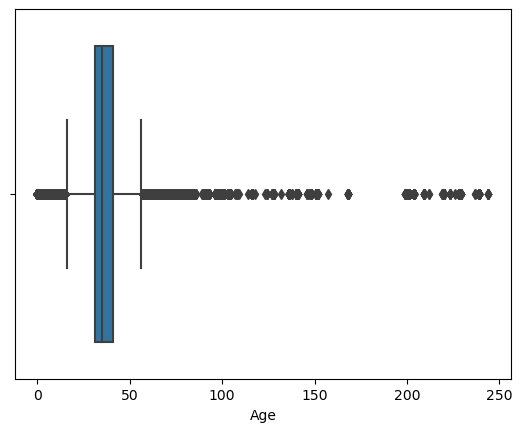

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='Age', data=train)
plt.show()

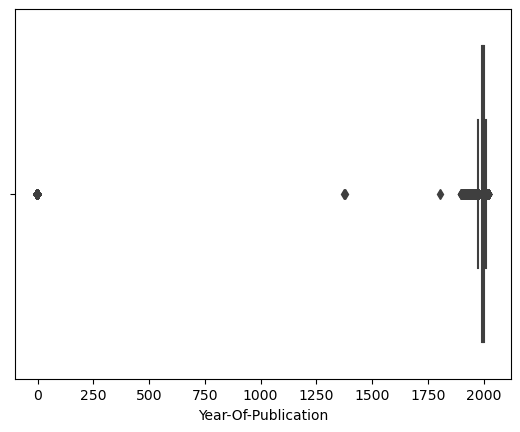

In [131]:
sns.boxplot(x='Year-Of-Publication', data=train)
plt.show()

In [153]:
#from lingua import Language, LanguageDetectorBuilder
from tqdm import tqdm
def columns_create():    
    global train_lb, test_lb
    # User-ID기준 Rating count & check
    count_columns = []
    check_columns = []
    for i in range(11):
        train_lb[f"count_{i}"] = train_lb[train_lb['Book-Rating'] == i].groupby(['User-ID'])['Book-Rating'].transform('count')
        train_lb[f"count_{i}"] = train_lb[f"count_{i}"].fillna(0)
    
        train_lb[f"check_{i}"] = np.where(train_lb[f"count_{i}"] > 0, 1, 0)        
        count_columns.append(f"count_{i}")
        check_columns.append(f"check_{i}")   
    create_columns = count_columns + check_columns
    for i in range(11):
        train_lb[f"count_{i}"] = train_lb.groupby(['User-ID'])[f"count_{i}"].transform('max')
        train_lb[f"check_{i}"] = train_lb.groupby(['User-ID'])[f"check_{i}"].transform('max')   
    ct_ck_set = train_lb[['User-ID'] + create_columns].drop_duplicates()
    test_lb = pd.merge(test_lb, ct_ck_set, on = 'User-ID', how = 'left')
    test_lb[create_columns] = test_lb[create_columns].fillna(0)    
    return count_columns, check_columns, train_lb, test_lb

def feature_engineering(df):

    # Book-Title로 도서 언어분류 (과적합 남)
    #df['prep_title'] = df['Book-Title'].apply(preprocessing_sentence)
    #detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().with_low_accuracy_mode().build()
    #
    #all = []
    #for row in tqdm(df['prep_title'].unique()):
    #    try:
    #        language = detector.detect_language_of(row)
    #    except:
    #        language = "error"
    #        print("This row throws and error:", row)
    #    all.append(language)
    #prep_title = pd.DataFrame(df['prep_title'].unique(), columns = ['prep_title'])
    #all = [i.name if str(i) != 'None' else 'None' for i in all]
    #Language = pd.DataFrame(all, columns = ['Language'])
    #prep_title = pd.concat([prep_title, Language], axis = 1)
    #df = pd.merge(df, prep_title, on = 'prep_title', how = 'inner')
    #
    #df = df.drop(columns = ['prep_title'])
    
    # Age 그룹화    
    #labels = ['0-3','3-6','6-8','8-12','12-18','18-54','55-64','65+']
    #bins = [0, 3, 6, 8, 12, 18, 54, 64, 250]
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 출판년도 그룹화
    # 만약 출판연도가 null이 있다면 정보없음(-1)로 채움
    df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(-1)
    labels = ['Unknown', '-1900', '1900-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    bins = [-1, 0, 1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)
    
    #count변수 추가(유명한 서적 or 유명 작가면 점수를 더 줄수도?)
    df['Rating_count'] = df.groupby('Book-Title')['Book-Title'].transform('count')
    df['Author_count'] = df.groupby('Book-Author')['Book-Author'].transform('count')
    
    # 빈도수는 log_scaling 작업을 해줌
    df['Rating_count'] = np.log1p(df['Rating_count'])
    df['Author_count'] = np.log1p(df['Author_count'])
    
    return df

In [154]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb']#', 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

count_columns, check_columns, train_lb, test_lb = columns_create()

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

#Kmean = KMeans(n_clusters=20, random_state=113, algorithm='auto')
#Kmean.fit(train_lb.drop(columns = ['ID', 'Book-Rating']))

#train_lb['cluster'] = Kmean.predict(train_lb.drop(columns = ['ID', 'Book-Rating']))
#test_lb['cluster'] = Kmean.predict(test_lb.drop(columns = ['ID']))

In [155]:
train_lb.to_csv('train_lb.csv')
test_lb.to_csv('test_lb.csv')

In [156]:
import pandas as pd

train_lb = pd.read_csv('train_lb.csv')
test_lb = pd.read_csv('test_lb.csv')

In [ ]:
# https://casa-de-feel.tistory.com/22 참고
#target='Book-Rating'
#Rating_mean_target_encoded=train_lb.groupby('User-ID')[target].mean()

#global_mean = train_lb[target].mean()
#alpha = 0.5

#def smoothing(n_rows, target_mean):
#    return (target_mean*n_rows + global_mean*alpha) / (n_rows + alpha)

#train_lb['Rating_encoded']=train_lb['User-ID'].map(Rating_mean_target_encoded)
#train_lb['Rating_encoded_smoothing'] = train_lb.apply(lambda x:smoothing(x['User_n_rows'], x['Rating_encoded']), axis=1)
#train_lb.head(20)

In [157]:
X_train = train_lb.drop(columns = ['Unnamed: 0', 'ID' , 'Book-Rating'])#, 'Rating_encoded', 'Rating_encoded_smoothing'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['Unnamed: 0', 'ID'])

In [16]:
list(set(X_train.columns) - set(FEATURE))

['Year-Of-Publication', 'Age', 'Rating_count', 'Author_count', 'User_n_rows']

In [158]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = StandardScaler()    # create an object of class

scaler_FEATURE = ['Age'] + count_columns
scaler.fit(X_train[scaler_FEATURE])       #  fit on training i/p data

X_train[scaler_FEATURE] = scaler.transform(X_train[scaler_FEATURE])    # transform model on both traing and testing data
x_test[scaler_FEATURE] = scaler.transform(x_test[scaler_FEATURE])

<Figure size 700x700 with 0 Axes>

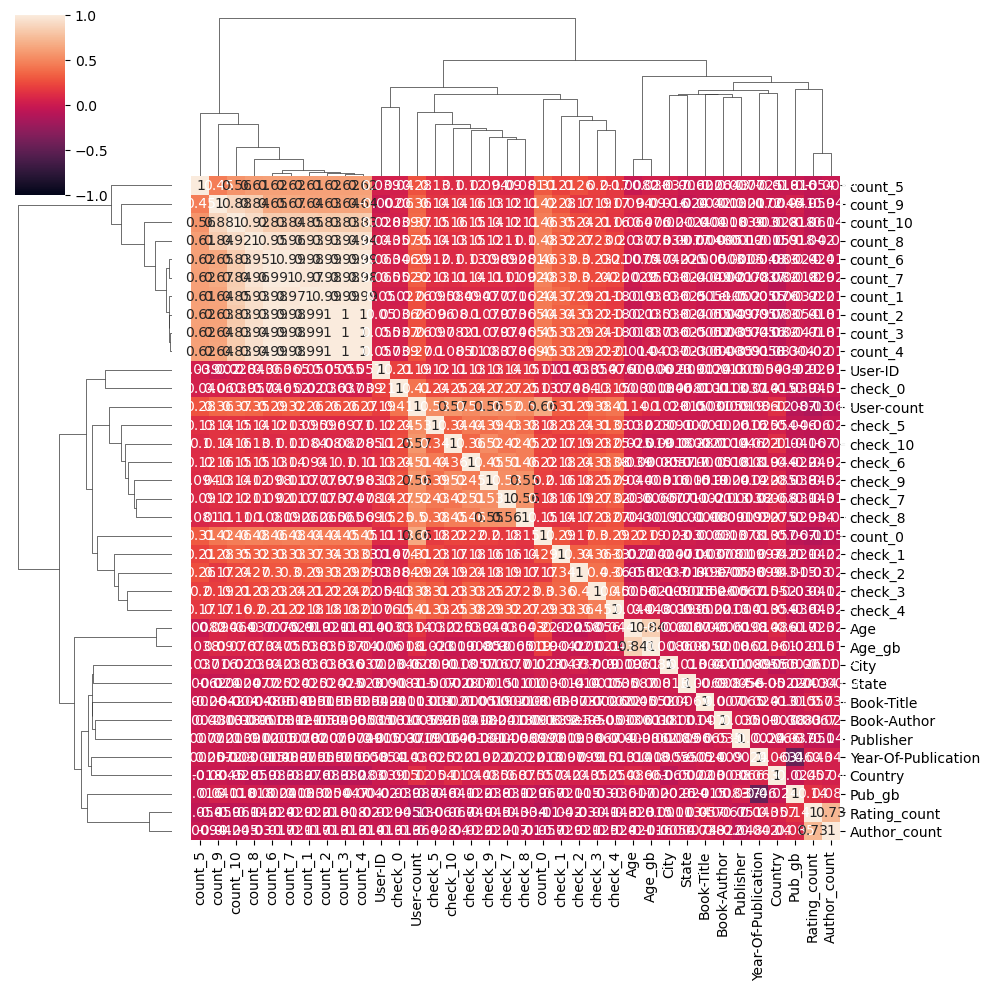

In [142]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), vmin = -1, vmax = 1, annot = True)

In [160]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8341185	test: 3.8406332	best: 3.8406332 (0)	total: 103ms	remaining: 14m 53s
500:	learn: 3.0261775	test: 3.0137415	best: 3.0137415 (500)	total: 52.2s	remaining: 14m 12s
1000:	learn: 2.9653113	test: 2.9736280	best: 2.9736280 (1000)	total: 1m 43s	remaining: 13m 14s
1500:	learn: 2.9227416	test: 2.9568685	best: 2.9568685 (1500)	total: 2m 34s	remaining: 12m 19s
2000:	learn: 2.8870816	test: 2.9483168	best: 2.9483121 (1999)	total: 3m 25s	remaining: 11m 28s
2500:	learn: 2.8547496	test: 2.9429327	best: 2.9429327 (2500)	total: 4m 22s	remaining: 10m 50s
3000:	learn: 2.8245442	test: 2.9396441	best: 2.9396436 (2999)	total: 5m 17s	remaining: 10m 1s
3500:	learn: 2.7955007	test: 2.9371343	best: 2.9371343 (3500)	total: 6m 8s	remaining: 9m 6s
4000:	learn: 2.7676643	test: 2.9354655	best: 2.9354616 (3998)	total: 6m 59s	remaining: 8m 11s
4500:	learn: 2.7416100	test: 2.9342512	best: 2.9342512 (4499)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 2.7160479	test: 2.9334636	best: 2.9334613 (4

1it [12:12, 732.66s/it]


Fold  1
0:	learn: 3.8353031	test: 3.8359013	best: 3.8359013 (0)	total: 103ms	remaining: 14m 56s
500:	learn: 3.0274120	test: 3.0107010	best: 3.0107010 (500)	total: 50.6s	remaining: 13m 48s
1000:	learn: 2.9659055	test: 2.9704659	best: 2.9704659 (1000)	total: 1m 42s	remaining: 13m 8s
1500:	learn: 2.9229353	test: 2.9544006	best: 2.9544006 (1500)	total: 2m 33s	remaining: 12m 17s
2000:	learn: 2.8871181	test: 2.9460319	best: 2.9460319 (2000)	total: 3m 25s	remaining: 11m 25s
2500:	learn: 2.8551966	test: 2.9404583	best: 2.9404583 (2500)	total: 4m 15s	remaining: 10m 33s
3000:	learn: 2.8241972	test: 2.9369051	best: 2.9369051 (3000)	total: 5m 6s	remaining: 9m 41s
3500:	learn: 2.7961446	test: 2.9344952	best: 2.9344952 (3500)	total: 5m 56s	remaining: 8m 49s
4000:	learn: 2.7688612	test: 2.9328084	best: 2.9328073 (3999)	total: 6m 47s	remaining: 7m 57s
4500:	learn: 2.7418709	test: 2.9314251	best: 2.9314237 (4498)	total: 7m 38s	remaining: 7m 6s
5000:	learn: 2.7162679	test: 2.9304023	best: 2.9304023 (50

2it [24:06, 721.38s/it]


Fold  2
0:	learn: 3.8371797	test: 3.8281781	best: 3.8281781 (0)	total: 99.9ms	remaining: 14m 28s
500:	learn: 3.0284236	test: 3.0008875	best: 3.0008875 (500)	total: 50.9s	remaining: 13m 52s
1000:	learn: 2.9672133	test: 2.9618803	best: 2.9618803 (1000)	total: 1m 41s	remaining: 13m 3s
1500:	learn: 2.9244122	test: 2.9465664	best: 2.9465664 (1500)	total: 2m 32s	remaining: 12m 12s
2000:	learn: 2.8879391	test: 2.9376442	best: 2.9376442 (2000)	total: 3m 24s	remaining: 11m 22s
2500:	learn: 2.8558861	test: 2.9324694	best: 2.9324694 (2500)	total: 4m 14s	remaining: 10m 30s
3000:	learn: 2.8259311	test: 2.9291780	best: 2.9291780 (3000)	total: 5m 5s	remaining: 9m 39s
3500:	learn: 2.7965912	test: 2.9268550	best: 2.9268550 (3500)	total: 5m 56s	remaining: 8m 48s
4000:	learn: 2.7693462	test: 2.9250082	best: 2.9250015 (3996)	total: 6m 46s	remaining: 7m 57s
4500:	learn: 2.7429056	test: 2.9237459	best: 2.9237428 (4499)	total: 7m 36s	remaining: 7m 5s
5000:	learn: 2.7177097	test: 2.9226818	best: 2.9226815 (4

3it [35:30, 704.31s/it]


Fold  3
0:	learn: 3.8359203	test: 3.8331209	best: 3.8331209 (0)	total: 104ms	remaining: 15m 1s
500:	learn: 3.0282132	test: 2.9994985	best: 2.9994985 (500)	total: 50.8s	remaining: 13m 49s
1000:	learn: 2.9684877	test: 2.9605604	best: 2.9605604 (1000)	total: 1m 41s	remaining: 13m
1500:	learn: 2.9270972	test: 2.9445107	best: 2.9445107 (1500)	total: 2m 32s	remaining: 12m 12s
2000:	learn: 2.8912219	test: 2.9362178	best: 2.9362178 (2000)	total: 3m 23s	remaining: 11m 22s
2500:	learn: 2.8590330	test: 2.9312872	best: 2.9312872 (2500)	total: 4m 14s	remaining: 10m 30s
3000:	learn: 2.8286130	test: 2.9279038	best: 2.9279034 (2999)	total: 5m 5s	remaining: 9m 39s
3500:	learn: 2.7997041	test: 2.9256649	best: 2.9256649 (3500)	total: 5m 55s	remaining: 8m 48s
4000:	learn: 2.7712218	test: 2.9239380	best: 2.9239380 (4000)	total: 6m 46s	remaining: 7m 56s
4500:	learn: 2.7440477	test: 2.9228451	best: 2.9228451 (4500)	total: 7m 37s	remaining: 7m 6s
5000:	learn: 2.7181166	test: 2.9220578	best: 2.9220575 (4999)	

4it [46:15, 681.11s/it]


Fold  4
0:	learn: 3.8345362	test: 3.8391624	best: 3.8391624 (0)	total: 103ms	remaining: 14m 54s
500:	learn: 3.0259643	test: 3.0147319	best: 3.0147319 (500)	total: 50.6s	remaining: 13m 47s
1000:	learn: 2.9661610	test: 2.9747987	best: 2.9747987 (1000)	total: 1m 41s	remaining: 12m 59s
1500:	learn: 2.9241421	test: 2.9582405	best: 2.9582405 (1500)	total: 2m 32s	remaining: 12m 10s
2000:	learn: 2.8894025	test: 2.9491225	best: 2.9491225 (2000)	total: 3m 23s	remaining: 11m 19s
2500:	learn: 2.8576981	test: 2.9437752	best: 2.9437752 (2500)	total: 4m 14s	remaining: 10m 29s
3000:	learn: 2.8272923	test: 2.9401848	best: 2.9401848 (3000)	total: 5m 5s	remaining: 9m 38s
3500:	learn: 2.7976014	test: 2.9375797	best: 2.9375774 (3493)	total: 5m 55s	remaining: 8m 47s
4000:	learn: 2.7700220	test: 2.9356411	best: 2.9356352 (3999)	total: 6m 46s	remaining: 7m 56s
4500:	learn: 2.7434834	test: 2.9341342	best: 2.9341342 (4500)	total: 7m 36s	remaining: 7m 5s
5000:	learn: 2.7174836	test: 2.9331627	best: 2.9331536 (4

5it [58:50, 706.01s/it]


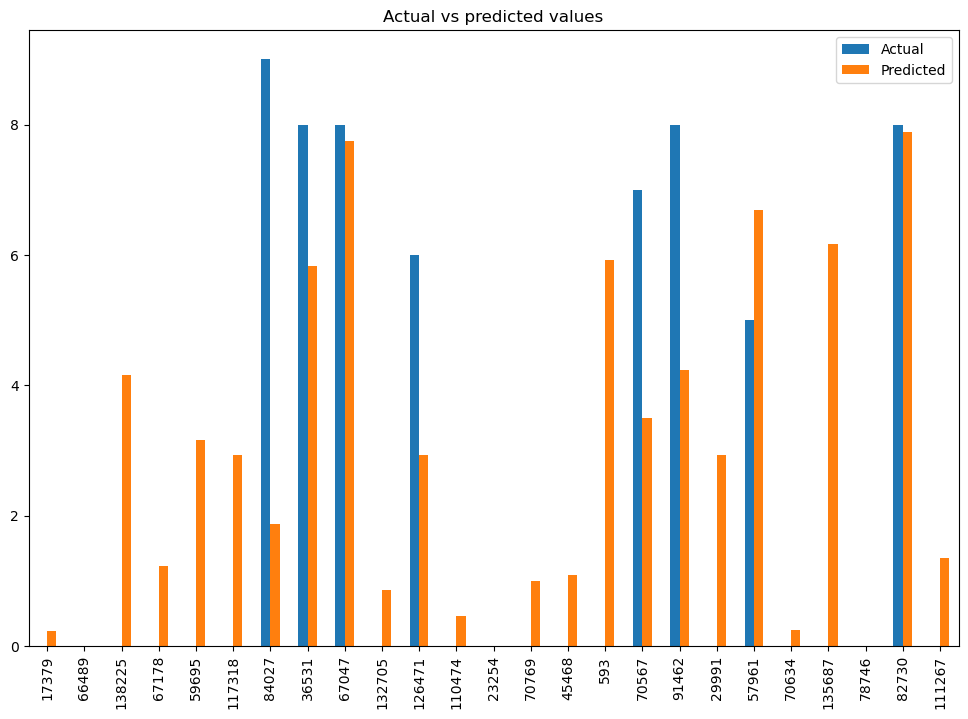

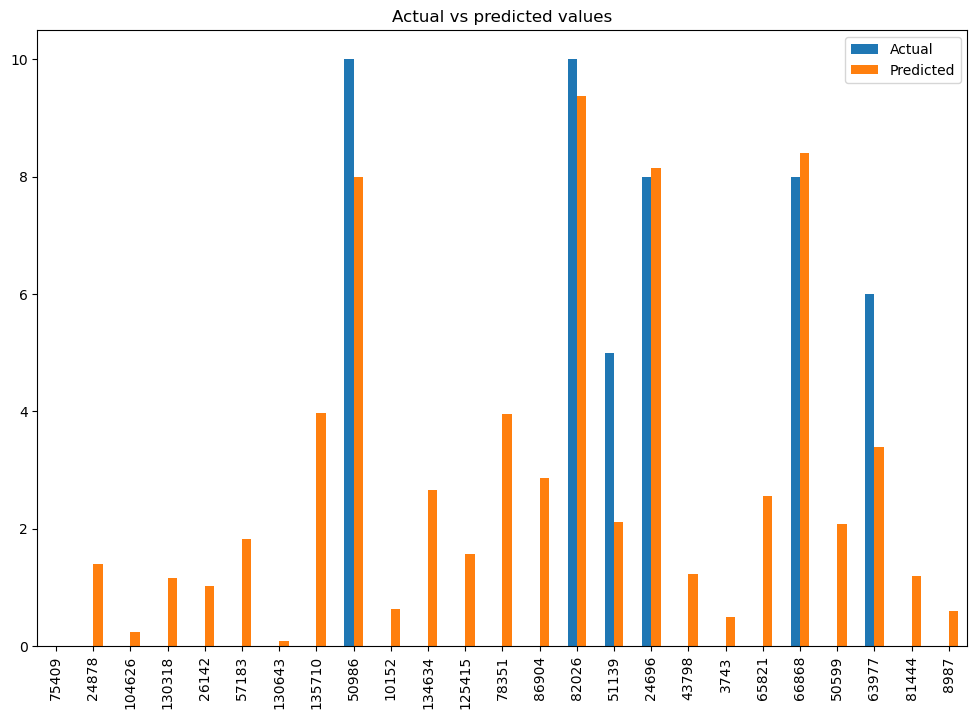

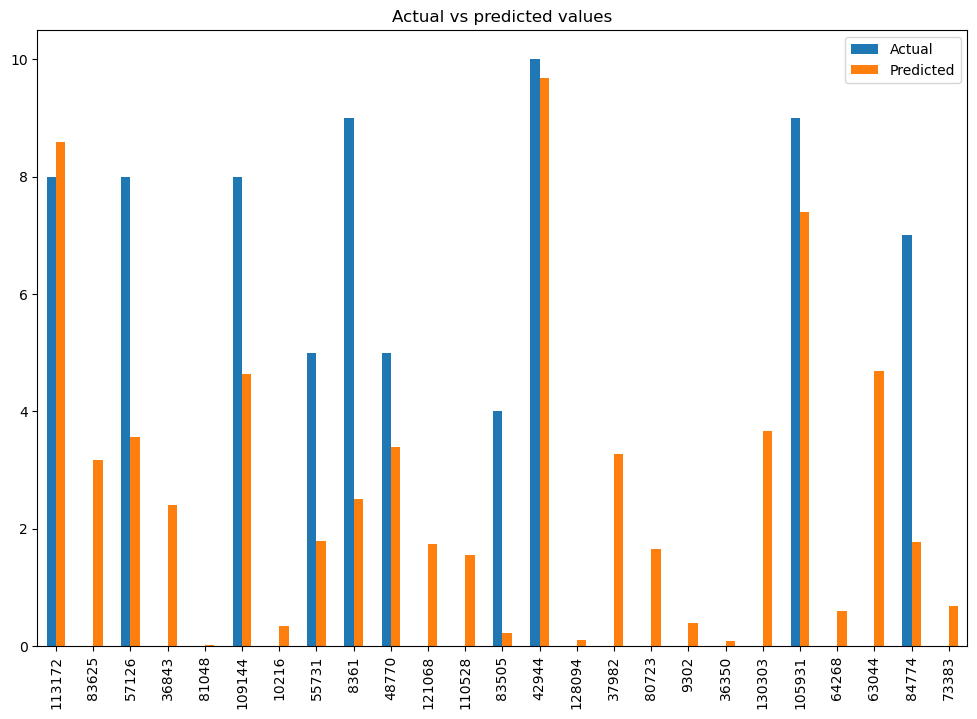

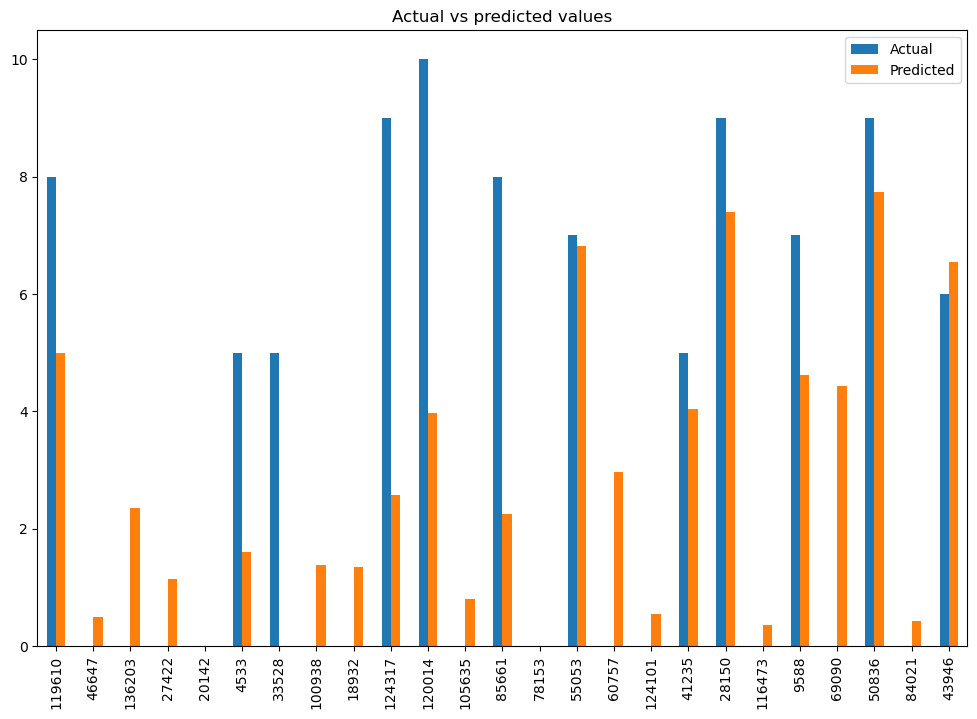

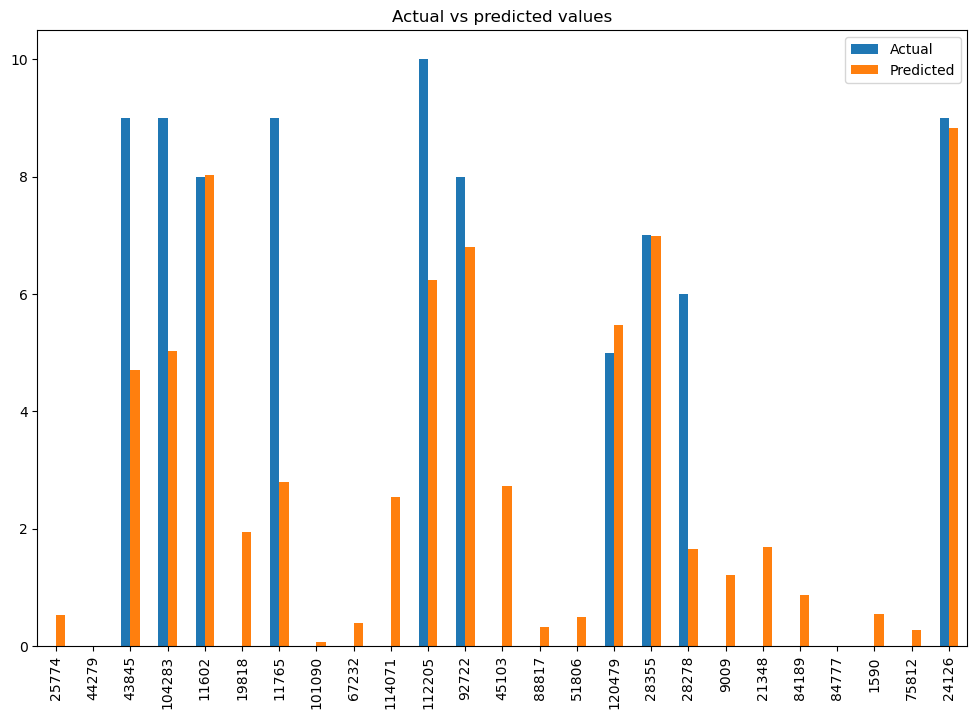

In [162]:
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

k = 5 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb'] + check_columns

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    # OVER SAMPLING - SMOTE
    #smote_sample = SMOTE(random_state=113, sampling_strategy='minority') 
    #X_train_fold, y_train_fold = smote_sample.fit_resample(X_train_fold, y_train_fold)
    #X_valid_fold, y_valid_fold = smote_sample.fit_resample(X_valid_fold, y_valid_fold)
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


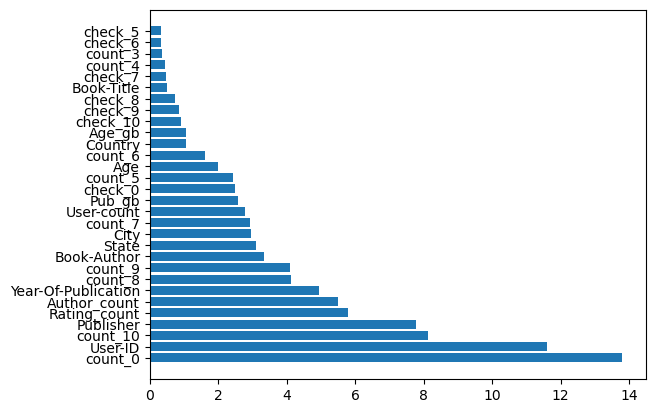

In [163]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [164]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,6.835588
1,TEST_000001,7.249934
2,TEST_000002,7.177673
3,TEST_000003,7.102758
4,TEST_000004,6.985786
...,...,...
159616,TEST_159616,2.376317
159617,TEST_159617,2.225439
159618,TEST_159618,2.235698
159619,TEST_159619,2.317529


<Axes: xlabel='Book-Rating', ylabel='Count'>

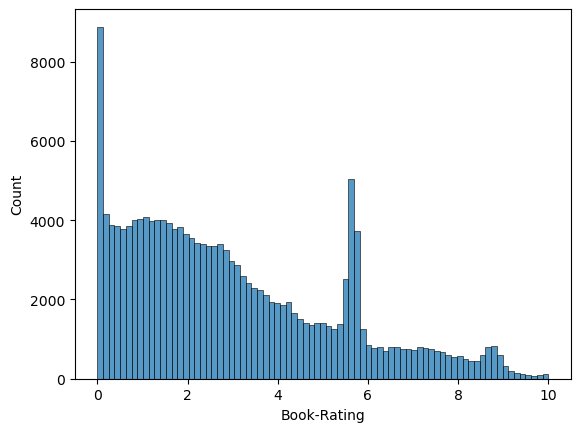

In [165]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [166]:
sub.to_csv('submit_cat+5-folds+Rating_ct.csv', index=False,encoding="utf-8-sig")